Questa cella importa i file JSON dalla directory corrente nella collezione `products` del database `roller_Deca`. La collezione deve essere svuotata (cella di codice commentata) se l'importazione avviene più di una volta, per evitare duplicati.

**Nota**: Assicurati che MongoDB sia in esecuzione con:
```bash
mongod --dbpath /Users/roberto/mongodb-data/db-new --fork --logpath /Users/roberto/mongodb-data/logs/mongod.log

# Packages

In [2]:
%pip install pymongo


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install matplotlib
%pip install seaborn
%pip install pandas


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Libraries

In [3]:
# Libraries
import os
import json
import pandas as pd
from pymongo import MongoClient
#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Importazione dei dati JSON in MongoDB

In [3]:
# Connessione al server MongoDB
client = MongoClient('mongodb://localhost:27017/')

In [4]:
# Seleziona il database e la collezione
db = client['roller_Deca']
collection = db['products']

In [5]:
# Svuota la collezione per evitare duplicati
collection.delete_many({})

DeleteResult({'n': 4776, 'ok': 1.0}, acknowledged=True)

In [6]:
# Percorso della cartella principale
base_directory = '/Users/roberto/Desktop/lavoro_stage_uni/decathlon_roller_products/2025'

for month in os.listdir(base_directory):
    month_path = os.path.join(base_directory, month)
    if os.path.isdir(month_path):
        # Itera sui file JSON nella sottocartella
        for filename in os.listdir(month_path):
            if filename.endswith('.json'):
                filepath = os.path.join(month_path, filename)
                try:
                    with open(filepath, 'r') as file:
                        data = json.load(file)
                        # Conta i documenti
                        num_docs = len(data) if isinstance(data, list) else 1
                        # Inserisci i dati
                        if isinstance(data, list):
                            collection.insert_many(data)
                        else:
                            collection.insert_one(data)
                        print(f"Importato: {filepath} ({num_docs} documenti)")
                except Exception as e:
                    print(f"Errore nell'importazione di {filepath}: {e}")

print("Importazione completata")
print(f"Totale documenti nella collezione: {collection.count_documents({})}")

Importato: /Users/roberto/Desktop/lavoro_stage_uni/decathlon_roller_products/2025/04/decathlon_roller_products_2025-04-25.json (696 documenti)
Importato: /Users/roberto/Desktop/lavoro_stage_uni/decathlon_roller_products/2025/04/decathlon_roller_products_2025-04-03.json (685 documenti)
Importato: /Users/roberto/Desktop/lavoro_stage_uni/decathlon_roller_products/2025/04/decathlon_roller_products_2025-04-18.json (701 documenti)
Importato: /Users/roberto/Desktop/lavoro_stage_uni/decathlon_roller_products/2025/04/decathlon_roller_products_2025-04-11.json (706 documenti)
Importato: /Users/roberto/Desktop/lavoro_stage_uni/decathlon_roller_products/2025/05/decathlon_roller_products_2025-05-09.json (670 documenti)
Importato: /Users/roberto/Desktop/lavoro_stage_uni/decathlon_roller_products/2025/05/decathlon_roller_products_2025-05-02.json (626 documenti)
Importato: /Users/roberto/Desktop/lavoro_stage_uni/decathlon_roller_products/2025/05/decathlon_roller_products_2025-05-17.json (692 documenti)

# KPI

### Query per prezzo medio per mese e categoria

In [7]:
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category"
            },
            "prezzo_medio": {"$avg": "$price(€)"}
        }
    },
    {"$sort": {"_id.mese": 1, "prezzo_medio": -1}}  # Prima mese (asc), poi prezzo_medio (desc)
]
risultati_KPI1 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI1:
    mese = ['Aprile', 'Maggio'][r['_id']['mese'] - 4]
    print(f"Mese: {mese}, Categoria: {r['_id']['categoria']}, Prezzo medio: {r['prezzo_medio']:.2f} €")

Mese: Aprile, Categoria: Roller, Prezzo medio: 137.47 €
Mese: Aprile, Categoria: Pattini a 4 ruote, Prezzo medio: 101.48 €
Mese: Aprile, Categoria: Accessori pattinaggio a rotelle, Prezzo medio: 42.50 €
Mese: Aprile, Categoria: Pattinaggio artistico a rotelle, Prezzo medio: 22.55 €
Mese: Aprile, Categoria: Ricambi pattini a rotelle, Prezzo medio: 19.14 €
Mese: Maggio, Categoria: Roller, Prezzo medio: 136.60 €
Mese: Maggio, Categoria: Pattini a 4 ruote, Prezzo medio: 92.10 €
Mese: Maggio, Categoria: Accessori pattinaggio a rotelle, Prezzo medio: 42.69 €
Mese: Maggio, Categoria: Pattinaggio artistico a rotelle, Prezzo medio: 28.14 €
Mese: Maggio, Categoria: Ricambi pattini a rotelle, Prezzo medio: 21.52 €


In [8]:
KPI1_dati = [
    {
        "Mese": ['Aprile', 'Maggio'][r['_id']['mese'] - 4],
        "Categoria": r['_id']['categoria'],
        "Prezzo medio (€)": round(r['prezzo_medio'], 2)
    }
    for r in risultati_KPI1
]

# DataFrame and table
avg_month_price_df = pd.DataFrame(KPI1_dati)
display(avg_month_price_df)

,Mese,Categoria,Prezzo medio (€)
0,Aprile,Roller,137.47
1,Aprile,Pattini a 4 ruote,101.48
2,Aprile,Accessori pattinaggio a rotelle,42.50
3,Aprile,Pattinaggio artistico a rotelle,22.55
4,Aprile,Ricambi pattini a rotelle,19.14
5,Maggio,Roller,136.60
6,Maggio,Pattini a 4 ruote,92.10
7,Maggio,Accessori pattinaggio a rotelle,42.69
8,Maggio,Pattinaggio artistico a rotelle,28.14
9,Maggio,Ricambi pattini a rotelle,21.52


In [11]:
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category",
                "sotto-categoria": "$subcategory"
            },
            "prezzo_medio": {"$avg": "$price(€)"}
        }
    },
    {"$sort": {"_id.mese": 1, "prezzo_medio": -1}}  # Prima mese (asc), poi prezzo_medio (desc)
]
risultati_KPI1_1 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI1_1:
    mese = ['Aprile', 'Maggio'][r['_id']['mese'] - 4]
    print(f"Mese: {mese}, Categoria: {r['_id']['categoria']}, Sotto-categoria: {r['_id']['sotto-categoria']}, Prezzo medio: {r['prezzo_medio']:.2f} €")

Mese: Aprile, Categoria: Roller, Sotto-categoria: Roller freeride, Prezzo medio: 160.37 €
Mese: Aprile, Categoria: Roller, Sotto-categoria: Roller adulto, Prezzo medio: 146.32 €
Mese: Aprile, Categoria: Roller, Sotto-categoria: Pattini hockey in linea, Prezzo medio: 127.99 €
Mese: Aprile, Categoria: Pattini a 4 ruote, Sotto-categoria: Pattini a 4 ruote, Prezzo medio: 107.89 €
Mese: Aprile, Categoria: Roller, Sotto-categoria: Roller bambino, Prezzo medio: 92.34 €
Mese: Aprile, Categoria: Accessori pattinaggio a rotelle, Sotto-categoria: Caschi Bici da Città, Prezzo medio: 74.56 €
Mese: Aprile, Categoria: Accessori pattinaggio a rotelle, Sotto-categoria: Pedala in città di notte, Prezzo medio: 73.29 €
Mese: Aprile, Categoria: Pattini a 4 ruote, Sotto-categoria: Pattini artistici a rotelle, Prezzo medio: 64.48 €
Mese: Aprile, Categoria: Pattinaggio artistico a rotelle, Sotto-categoria: Pattini artistici a rotelle, Prezzo medio: 63.16 €
Mese: Aprile, Categoria: Accessori pattinaggio a rote

In [12]:
KPI1_1_dati = [
    {
        "Mese": "Aprile",
        "Categoria": r['_id']['categoria'],
        "Sotto-categoria": r['_id']['sotto-categoria'],
        "Prezzo medio (€)": round(r['prezzo_medio'], 2)
    }
    for r in risultati_KPI1_1
    if r['_id']['mese'] == 4
]

# DataFrame and table
avg_month_sub_price_df = pd.DataFrame(KPI1_1_dati)
pd.set_option('display.max_rows', None)
display(avg_month_sub_price_df)

,Mese,Categoria,Sotto-categoria,Prezzo medio (€)
0,Aprile,Roller,Roller freeride,160.37
1,Aprile,Roller,Roller adulto,146.32
2,Aprile,Roller,Pattini hockey in linea,127.99
3,Aprile,Pattini a 4 ruote,Pattini a 4 ruote,107.89
4,Aprile,Roller,Roller bambino,92.34
5,Aprile,Accessori pattinaggio a rotelle,Caschi Bici da Città,74.56
6,Aprile,Accessori pattinaggio a rotelle,Pedala in città di notte,73.29
7,Aprile,Pattini a 4 ruote,Pattini artistici a rotelle,64.48
8,Aprile,Pattinaggio artistico a rotelle,Pattini artistici a rotelle,63.16
9,Aprile,Accessori pattinaggio a rotelle,Caschi,41.62


In [13]:
KPI1_1_dati = [
    {
        "Mese": "Maggio",
        "Categoria": r['_id']['categoria'],
        "Sotto-categoria": r['_id']['sotto-categoria'],
        "Prezzo medio (€)": round(r['prezzo_medio'], 2)
    }
    for r in risultati_KPI1_1
    if r['_id']['mese'] == 5
]

# DataFrame and table
avg_month_sub_price_df = pd.DataFrame(KPI1_1_dati)
pd.set_option('display.max_rows', None)
display(avg_month_sub_price_df)

,Mese,Categoria,Sotto-categoria,Prezzo medio (€)
0,Maggio,Roller,Roller freeride,153.39
1,Maggio,Roller,Roller adulto,149.79
2,Maggio,Roller,Pattini hockey in linea,127.99
3,Maggio,Pattini a 4 ruote,Pattini a 4 ruote,97.17
4,Maggio,Roller,Roller bambino,88.42
5,Maggio,Accessori pattinaggio a rotelle,Pedala in città di notte,73.29
6,Maggio,Accessori pattinaggio a rotelle,Caschi Bici da Città,70.90
7,Maggio,Pattinaggio artistico a rotelle,Pattini artistici a rotelle,70.25
8,Maggio,Pattini a 4 ruote,Pattini artistici a rotelle,70.20
9,Maggio,Accessori pattinaggio a rotelle,Caschi,46.27


### KPI: Top 5 prodotti per numero di recensioni

In [14]:
pipeline = [
    {"$group": {"_id": {"nome": "$name", "brand": "$brand"}, "recensioni_totali": {"$sum": "$num_reviews"}}},
    {"$sort": {"recensioni_totali": -1}},
    {"$limit": 5}
]
risultati_KPI2 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI2:
    print(f"Prodotto: {r['_id']['brand']} {r['_id']['nome']}, Recensioni: {r['recensioni_totali']}")

Prodotto: OXELO Casco roller skateboard monopattino MF500 nero-azzurro, Recensioni: 38277
Prodotto: OXELO Roller fitness bambino FIT3 ABYSS GREY, Recensioni: 35273
Prodotto: OXELO Roller bambino PLAY3 blu-rosso, Recensioni: 30193
Prodotto: OXELO Protezioni roller monopattino skate bambini ILS PLAY CAKTUS, Recensioni: 27015
Prodotto: BTWIN Casco bici città bowl 500 nero, Recensioni: 19249


### KPI: Sconto medio settimanale

In [15]:
pipeline = [
    {
        "$group": {
            "_id": {
                "$dateToString": {
                    "format": "%Y-%m-%d",
                    "date": {"$toDate": "$scraped_at"}
                }
            },
            "sconto_medio": {"$avg": "$sale%"}
        }
    },
    {"$sort": {"_id": 1}}
]
risultati_KPI3 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI3:
    print(f"Data: {r['_id']}, Sconto medio: {r['sconto_medio']:.2f}%")

Data: 2025-04-03, Sconto medio: 21.08%
Data: 2025-04-11, Sconto medio: 20.69%
Data: 2025-04-18, Sconto medio: 20.26%
Data: 2025-04-25, Sconto medio: 20.75%
Data: 2025-05-02, Sconto medio: 21.48%
Data: 2025-05-09, Sconto medio: 22.70%
Data: 2025-05-17, Sconto medio: 21.91%


In [16]:
KPI3_dati = [
    {
        "Data": r['_id'],
        "Sconto medio (%)": round(r['sconto_medio'], 2)
    }
    for r in risultati_KPI3
]

# DataFrame e tabella
avg_week_discount_df = pd.DataFrame(KPI3_dati)
display(avg_week_discount_df)

,Data,Sconto medio (%)
0,2025-04-03,21.08
1,2025-04-11,20.69
2,2025-04-18,20.26
3,2025-04-25,20.75
4,2025-05-02,21.48
5,2025-05-09,22.70
6,2025-05-17,21.91


### KPI: sconto medio per settimana e categoria

In [17]:
pipeline = [
    {
        "$group": {
            "_id": {
                "data": {
                    "$dateToString": {
                        "format": "%Y-%m-%d",
                        "date": {"$toDate": "$scraped_at"}
                    }
                },
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category"
            },
            "sconto_medio": {"$avg": "$sale%"}
        }
    },
    {"$sort": {"_id.data": 1, "_id.mese": 1, "_id.categoria": 1}}
]
risultati_KPI3_1 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI3_1:
    mese = ['Aprile', 'Maggio'][r['_id']['mese'] - 4]
    print(f"Data: {r['_id']['data']}, Mese: {mese}, Categoria: {r['_id']['categoria']}, Sconto medio: {r['sconto_medio']:.2f}%")

Data: 2025-04-03, Mese: Aprile, Categoria: Accessori pattinaggio a rotelle, Sconto medio: 18.86%
Data: 2025-04-03, Mese: Aprile, Categoria: Pattinaggio artistico a rotelle, Sconto medio: 61.00%
Data: 2025-04-03, Mese: Aprile, Categoria: Pattini a 4 ruote, Sconto medio: 26.20%
Data: 2025-04-03, Mese: Aprile, Categoria: Ricambi pattini a rotelle, Sconto medio: 20.00%
Data: 2025-04-03, Mese: Aprile, Categoria: Roller, Sconto medio: 21.43%
Data: 2025-04-11, Mese: Aprile, Categoria: Accessori pattinaggio a rotelle, Sconto medio: 17.77%
Data: 2025-04-11, Mese: Aprile, Categoria: Pattinaggio artistico a rotelle, Sconto medio: 61.00%
Data: 2025-04-11, Mese: Aprile, Categoria: Pattini a 4 ruote, Sconto medio: 25.25%
Data: 2025-04-11, Mese: Aprile, Categoria: Ricambi pattini a rotelle, Sconto medio: 17.50%
Data: 2025-04-11, Mese: Aprile, Categoria: Roller, Sconto medio: 21.68%
Data: 2025-04-18, Mese: Aprile, Categoria: Accessori pattinaggio a rotelle, Sconto medio: 17.92%
Data: 2025-04-18, Mese:

In [18]:
KPI3_1_dati = [
    {
        "Data": r['_id']['data'],
        "Mese": "Aprile",
        "Categoria": r['_id']['categoria'],
        "Sconto medio (%)": round(r['sconto_medio'], 2)
    }
    for r in risultati_KPI3_1
    if r['_id']['mese'] == 4
]

# DataFrame and table
avg_week_cat_sale_df4 = pd.DataFrame(KPI3_1_dati)
pd.set_option('display.max_rows', None)
display(avg_week_cat_sale_df4)

,Data,Mese,Categoria,Sconto medio (%)
0,2025-04-03,Aprile,Accessori pattinaggio a rotelle,18.86
1,2025-04-03,Aprile,Pattinaggio artistico a rotelle,61.00
2,2025-04-03,Aprile,Pattini a 4 ruote,26.20
3,2025-04-03,Aprile,Ricambi pattini a rotelle,20.00
4,2025-04-03,Aprile,Roller,21.43
5,2025-04-11,Aprile,Accessori pattinaggio a rotelle,17.77
6,2025-04-11,Aprile,Pattinaggio artistico a rotelle,61.00
7,2025-04-11,Aprile,Pattini a 4 ruote,25.25
8,2025-04-11,Aprile,Ricambi pattini a rotelle,17.50
9,2025-04-11,Aprile,Roller,21.68


In [19]:
KPI3_1_dati = [
    {
        "Data": r['_id']['data'],
        "Mese": "Maggio",
        "Categoria": r['_id']['categoria'],
        "Sconto medio (%)": round(r['sconto_medio'], 2)
    }
    for r in risultati_KPI3_1
    if r['_id']['mese'] == 5
]

# DataFrame and table
avg_week_cat_sale_df5 = pd.DataFrame(KPI3_1_dati)
pd.set_option('display.max_rows', None)
display(avg_week_cat_sale_df5)

,Data,Mese,Categoria,Sconto medio (%)
0,2025-05-02,Maggio,Accessori pattinaggio a rotelle,17.43
1,2025-05-02,Maggio,Pattinaggio artistico a rotelle,61.00
2,2025-05-02,Maggio,Pattini a 4 ruote,22.86
3,2025-05-02,Maggio,Ricambi pattini a rotelle,15.00
4,2025-05-02,Maggio,Roller,23.98
5,2025-05-09,Maggio,Accessori pattinaggio a rotelle,20.00
6,2025-05-09,Maggio,Pattinaggio artistico a rotelle,61.00
7,2025-05-09,Maggio,Pattini a 4 ruote,25.00
8,2025-05-09,Maggio,Ricambi pattini a rotelle,17.50
9,2025-05-09,Maggio,Roller,24.27


### KPI: Sconto Medio per Mese e Categoria

In [20]:
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category"
            },
            "sconto_medio": {"$avg": "$sale%"}
        }
    },
    {"$sort": {"_id.mese": 1, "prezzo_medio": -1}}  # Prima mese (asc), poi prezzo_medio (desc)
]
risultati_KPI4 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI4:
    mese = ['Aprile', 'Maggio'][r['_id']['mese'] - 4]
    print(f"Mese: {mese}, Categoria: {r['_id']['categoria']}, Sconto medio: {r['sconto_medio']:.2f} %")

Mese: Aprile, Categoria: Pattinaggio artistico a rotelle, Sconto medio: 61.00 %
Mese: Aprile, Categoria: Ricambi pattini a rotelle, Sconto medio: 17.86 %
Mese: Aprile, Categoria: Accessori pattinaggio a rotelle, Sconto medio: 18.11 %
Mese: Aprile, Categoria: Roller, Sconto medio: 21.36 %
Mese: Aprile, Categoria: Pattini a 4 ruote, Sconto medio: 25.33 %
Mese: Maggio, Categoria: Ricambi pattini a rotelle, Sconto medio: 17.00 %
Mese: Maggio, Categoria: Accessori pattinaggio a rotelle, Sconto medio: 18.84 %
Mese: Maggio, Categoria: Pattinaggio artistico a rotelle, Sconto medio: 61.00 %
Mese: Maggio, Categoria: Pattini a 4 ruote, Sconto medio: 25.23 %
Mese: Maggio, Categoria: Roller, Sconto medio: 23.81 %


In [55]:
KPI4_1_dati = [
    {
        "Mese": "Aprile",
        "Categoria": r['_id']['categoria'],
        "Sconto medio (%)": round(r['sconto_medio'], 2)
    }
    for r in risultati_KPI4
    if r['_id']['mese'] == 4
]

# DataFrame and table
avg_month_cat_sale_df = pd.DataFrame(KPI4_1_dati)
pd.set_option('display.max_rows', None)
display(avg_month_cat_sale_df.sort_values(by='Sconto medio (%)', ascending=False))

,Mese,Categoria,Sconto medio (%)
1,Aprile,Pattinaggio artistico a rotelle,61.00
0,Aprile,Pattini a 4 ruote,25.33
3,Aprile,Roller,21.36
4,Aprile,Accessori pattinaggio a rotelle,18.11
2,Aprile,Ricambi pattini a rotelle,17.86


In [56]:
KPI4_1_dati = [
    {
        "Mese": "Maggio",
        "Categoria": r['_id']['categoria'],
        "Sconto medio (%)": round(r['sconto_medio'], 2)
    }
    for r in risultati_KPI4
    if r['_id']['mese'] == 5
]

# DataFrame and table
avg_month_cat_sale_df = pd.DataFrame(KPI4_1_dati)
pd.set_option('display.max_rows', None)
display(avg_month_cat_sale_df.sort_values(by='Sconto medio (%)', ascending=False))

,Mese,Categoria,Sconto medio (%)
2,Maggio,Pattinaggio artistico a rotelle,61.00
3,Maggio,Pattini a 4 ruote,25.23
0,Maggio,Roller,23.81
4,Maggio,Accessori pattinaggio a rotelle,18.84
1,Maggio,Ricambi pattini a rotelle,17.00


### KPI: Punteggio Medio per Categorie e Mese

In [64]:
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category"
            },
            "punteggio_medio": {"$avg": "$score/5"}
        }
    },
    {"$sort": {"_id.mese": 1, "punteggio_medio": -1}}  
]
risultati_KPI5 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI5:
    mese = ['Aprile', 'Maggio'][r['_id']['mese'] - 4]
    print(f"Mese: {mese}, Categoria: {r['_id']['categoria']}, Punteggio medio: {r['punteggio_medio']:.2f}/5")

Mese: Aprile, Categoria: Pattinaggio artistico a rotelle, Punteggio medio: 4.69/5
Mese: Aprile, Categoria: Accessori pattinaggio a rotelle, Punteggio medio: 4.66/5
Mese: Aprile, Categoria: Pattini a 4 ruote, Punteggio medio: 4.63/5
Mese: Aprile, Categoria: Roller, Punteggio medio: 4.56/5
Mese: Aprile, Categoria: Ricambi pattini a rotelle, Punteggio medio: 4.52/5
Mese: Maggio, Categoria: Pattinaggio artistico a rotelle, Punteggio medio: 4.80/5
Mese: Maggio, Categoria: Accessori pattinaggio a rotelle, Punteggio medio: 4.68/5
Mese: Maggio, Categoria: Pattini a 4 ruote, Punteggio medio: 4.57/5
Mese: Maggio, Categoria: Ricambi pattini a rotelle, Punteggio medio: 4.54/5
Mese: Maggio, Categoria: Roller, Punteggio medio: 4.54/5


In [65]:
KPI5_dati = [
    {
        "Mese": "Aprile",
        "Categoria": r['_id']['categoria'],
        "Punteggio medio (/5)": round(r['punteggio_medio'], 2)
    }
    for r in risultati_KPI5
    if r['_id']['mese'] == 4
]

# DataFrame e tabella
score_medio_df = pd.DataFrame(KPI5_dati)
display(score_medio_df)

,Mese,Categoria,Punteggio medio (/5)
0,Aprile,Pattinaggio artistico a rotelle,4.69
1,Aprile,Accessori pattinaggio a rotelle,4.66
2,Aprile,Pattini a 4 ruote,4.63
3,Aprile,Roller,4.56
4,Aprile,Ricambi pattini a rotelle,4.52


In [66]:
KPI5_dati = [
    {
        "Mese": "Maggio",
        "Categoria": r['_id']['categoria'],
        "Punteggio medio (/5)": round(r['punteggio_medio'], 2)
    }
    for r in risultati_KPI5
    if r['_id']['mese'] == 5
]

# DataFrame e tabella
score_medio_df = pd.DataFrame(KPI5_dati)
display(score_medio_df)

,Mese,Categoria,Punteggio medio (/5)
0,Maggio,Pattinaggio artistico a rotelle,4.80
1,Maggio,Accessori pattinaggio a rotelle,4.68
2,Maggio,Pattini a 4 ruote,4.57
3,Maggio,Ricambi pattini a rotelle,4.54
4,Maggio,Roller,4.54


### KPI: Top 10 Prodotti per Punteggio Medio

In [70]:
pipeline = [
    {
        "$group": {
            "_id": {
                "brand": "$brand",
                "nome": "$name",
                "categoria": "$category"
            },
            "punteggio_medio": {"$avg": "$score/5"},
            "recensioni_totali": {"$sum": "$num_reviews"}  
        }
    },
    {"$sort": {"punteggio_medio": -1, "recensioni_totali": -1}},  # Ordina per punteggio, poi recensioni
    {"$limit": 10}
]
risultati_KPI6 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI6:
    print(f"Prodotto: {r['_id']['brand']} {r['_id']['nome']}, Categoria: {r['_id']['categoria']}, "
          f"Punteggio medio: {r['punteggio_medio']:.2f}/5, Recensioni: {r['recensioni_totali']}")

Prodotto: RAVEN Pattini a rotelle Pattini regolabili 4in1 ruote Isla LED, Categoria: Roller, Punteggio medio: 5.00/5, Recensioni: 172
Prodotto: RAVEN Pattini regolabili Pulse Nero/Ciano, Categoria: Roller, Punteggio medio: 5.00/5, Recensioni: 166
Prodotto: RAVEN Pattini a rotelle regolabili Classic Lexie Ombre, Categoria: Roller, Punteggio medio: 5.00/5, Recensioni: 70
Prodotto: RAVEN Pattini a rotelle 3in1 ruote luminose LED Isla Viola/Menta, Categoria: Roller, Punteggio medio: 5.00/5, Recensioni: 58
Prodotto: RAVEN Pattini Classic Retro Regolabili Serena Nero/Menta, Categoria: Pattini a 4 ruote, Punteggio medio: 5.00/5, Recensioni: 54
Prodotto: RAVEN Pattini a rotelle regolabili 3in1 Profession Black/Lime, Categoria: Roller, Punteggio medio: 5.00/5, Recensioni: 47
Prodotto: RAVEN Pattini a rotelle regolabili 2in1 Expert, Categoria: Roller, Punteggio medio: 5.00/5, Recensioni: 43
Prodotto: FILA Freni roller STANDARD nero, Categoria: Ricambi pattini a rotelle, Punteggio medio: 5.00/5, 

### KPI: Punteggio medio per brand (ordinati per numero recensioni)

In [27]:
pipeline = [
    {
        "$group": {
            "_id": "$brand",
            "punteggio_medio": {"$avg": "$score/5"},
            "recensioni_totali": {"$sum": "$num_reviews"}
        }
    },
    {"$sort": {"recensioni_totali": -1}}  # Ordina per numero recensioni (desc)
]
risultati_KPI7 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI7:
    punteggio = f"{r['punteggio_medio']:.2f}" if r['punteggio_medio'] is not None else "N/A"
    print(f"Brand: {r['_id']}, Punteggio medio: {punteggio}/5, Recensioni: {r['recensioni_totali']}")

Brand: OXELO, Punteggio medio: 4.58/5, Recensioni: 258217
Brand: BTWIN, Punteggio medio: 4.68/5, Recensioni: 64549
Brand: DECATHLON, Punteggio medio: 4.75/5, Recensioni: 18403
Brand: KIPSTA, Punteggio medio: 4.83/5, Recensioni: 8232
Brand: RAVEN, Punteggio medio: 4.70/5, Recensioni: 3608
Brand: ABUS, Punteggio medio: 4.61/5, Recensioni: 1703
Brand: YEEP.ME, Punteggio medio: 4.10/5, Recensioni: 956
Brand: POWERSLIDE, Punteggio medio: 4.79/5, Recensioni: 528
Brand: BLACKWHEELS, Punteggio medio: 4.32/5, Recensioni: 365
Brand: FILA, Punteggio medio: 4.46/5, Recensioni: 365
Brand: AXELYS, Punteggio medio: 4.68/5, Recensioni: 338
Brand: CRAZY SAFETY, Punteggio medio: 4.73/5, Recensioni: 285
Brand: MOVINO, Punteggio medio: 4.76/5, Recensioni: 216
Brand: ROCES, Punteggio medio: 4.05/5, Recensioni: 216
Brand: LIVALL, Punteggio medio: 4.18/5, Recensioni: 155
Brand: APOLLO, Punteggio medio: 3.28/5, Recensioni: 144
Brand: ROXA, Punteggio medio: 4.21/5, Recensioni: 142
Brand: ATTABO, Punteggio medi

In [31]:
KPI7_dati = [
    {
        "Brand": r['_id'],
        "Punteggio medio (/5)": round(r['punteggio_medio'], 2) if r['punteggio_medio'] is not None else "N/A",
        "Recensioni totali": r['recensioni_totali']
    }
    for r in risultati_KPI7
]

# DataFrame e tabella
brand_score_df = pd.DataFrame(risultati_KPI7)
pd.set_option('display.max_rows', None)
display(brand_score_df)

,_id,punteggio_medio,recensioni_totali
0,OXELO,4.584596,258217
1,BTWIN,4.677215,64549
2,DECATHLON,4.746575,18403
3,KIPSTA,4.830769,8232
4,RAVEN,4.697195,3608
5,ABUS,4.607143,1703
6,YEEP.ME,4.100000,956
7,POWERSLIDE,4.792308,528
8,BLACKWHEELS,4.324324,365
9,FILA,4.457407,365


#### Top 10 Brand per Numero Recensioni

In [33]:
display(brand_score_df[:10])

,_id,punteggio_medio,recensioni_totali
0,OXELO,4.584596,258217
1,BTWIN,4.677215,64549
2,DECATHLON,4.746575,18403
3,KIPSTA,4.830769,8232
4,RAVEN,4.697195,3608
5,ABUS,4.607143,1703
6,YEEP.ME,4.100000,956
7,POWERSLIDE,4.792308,528
8,BLACKWHEELS,4.324324,365
9,FILA,4.457407,365


#### Top 10 Brand per Score Medio

In [34]:
display(brand_score_df.sort_values(by='punteggio_medio', ascending=False)[:10])

,_id,punteggio_medio,recensioni_totali
35,INVERT,5.00,7
38,TRIGGER,5.00,6
29,YVOLUTION,5.00,14
30,MOTUS,5.00,12
33,LAZER,5.00,7
34,NILS EXTREME,5.00,7
36,HUDORA,5.00,6
27,MICRO SKATE,5.00,24
23,ROLLERBLADE,4.90,52
26,OLSSON AND BROTHERS,4.88,30


### KPI: Variazione di prezzo per prodotto

In [39]:
# Query per variazione di prezzo
pipeline = [
    {
        "$group": {
            "_id": {
                "brand": "$brand",
                "nome": "$name",
                "settimana": {
                    "$dateToString": {"format": "%Y-%m-%d", "date": {"$toDate": "$scraped_at"}}
                }
            },
            "prezzo_medio": {"$avg": "$price(€)"}
        }
    },
    {
        "$sort": {"_id.brand": 1, "_id.nome": 1, "_id.settimana": 1}
    },
    {
        "$group": {
            "_id": {"brand": "$_id.brand", "nome": "$_id.nome"},
            "prezzi": {
                "$push": {
                    "settimana": "$_id.settimana",
                    "prezzo": "$prezzo_medio"
                }
            }
        }
    },
    {
        "$project": {
            "variazione_max": {
                "$subtract": [
                    {"$max": "$prezzi.prezzo"},
                    {"$min": "$prezzi.prezzo"}
                ]
            }
        }
    },
    {"$sort": {"variazione_max": -1}},
    {"$limit": 5}
]
risultati_KPI8 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI8:
    print(f"Prodotto: {r['_id']['brand']} {r['_id']['nome']}, Variazione prezzo: {r['variazione_max']:.2f} €")

Prodotto: FILA Pattini in Linea Fitness Adulto HOUDINI EVO Nero, Variazione prezzo: 156.75 €
Prodotto: FILA Pattini in linea da uomo FILA Argon 84, Variazione prezzo: 156.51 €
Prodotto: FILA Pattini in linea da uomo FILA Legacy Pro 80, Variazione prezzo: 130.20 €
Prodotto: FILA Pattini in Linea Bambino X-ONE Nero, Variazione prezzo: 107.50 €
Prodotto: FILA SKATES Pattini in linea da uomo FILA Legacy Pro 100, Variazione prezzo: 91.10 €


In [40]:
KPI8_dati = [
    {
        "Prodotto": f"{r['_id']['brand']} {r['_id']['nome']}",
        "Variazione prezzo (€)": round(r['variazione_max'], 2)
    }
    for r in risultati_KPI8
]

# DataFrame e tabella
variazione_prezzo_df = pd.DataFrame(KPI8_dati)
display(variazione_prezzo_df)

,Prodotto,Variazione prezzo (€)
0,FILA Pattini in Linea Fitness Adulto HOUDINI E...,156.75
1,FILA Pattini in linea da uomo FILA Argon 84,156.51
2,FILA Pattini in linea da uomo FILA Legacy Pro 80,130.20
3,FILA Pattini in Linea Bambino X-ONE Nero,107.50
4,FILA SKATES Pattini in linea da uomo FILA Lega...,91.10


### KPI: % di prodotti in sconto per categoria

In [49]:
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category"
            },
            "totale_prodotti": {"$sum": 1},
            "prodotti_in_sconto": {
                "$sum": {
                    "$cond": [
                        {
                            "$gt": [
                                {
                                    "$toDouble": {
                                        "$cond": [
                                            {"$eq": ["$sale%", "Not on sale"]},
                                            0,
                                            "$sale%"
                                        ]
                                    }
                                },
                                0
                            ]
                        },
                        1,
                        0
                    ]
                }
            }
        }
    },
    {
        "$project": {
            "totale_prodotti": 1,
            "prodotti_in_sconto": 1,
            "percentuale_sconto": {
                "$multiply": [
                    {"$divide": ["$prodotti_in_sconto", "$totale_prodotti"]},
                    100
                ]
            }
        }
    },
    {"$sort": {"_id.mese": 1, "percentuale_sconto": -1}}
]
risultati_KPI9 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI9:
    mese = ['Aprile', 'Maggio'][r['_id']['mese'] - 4]
    print(
        f"Mese: {mese}, Categoria: {r['_id']['categoria']}, "
        f"Prodotti in sconto: {r.get('prodotti_in_sconto', 0)}, "
        f"Totale prodotti: {r.get('totale_prodotti', 0)}, "
        f"Percentuale in sconto: {r.get('percentuale_sconto', 0):.2f}%"
    )

Mese: Aprile, Categoria: Pattini a 4 ruote, Prodotti in sconto: 30, Totale prodotti: 122, Percentuale in sconto: 24.59%
Mese: Aprile, Categoria: Accessori pattinaggio a rotelle, Prodotti in sconto: 153, Totale prodotti: 702, Percentuale in sconto: 21.79%
Mese: Aprile, Categoria: Pattinaggio artistico a rotelle, Prodotti in sconto: 4, Totale prodotti: 34, Percentuale in sconto: 11.76%
Mese: Aprile, Categoria: Roller, Prodotti in sconto: 171, Totale prodotti: 1711, Percentuale in sconto: 9.99%
Mese: Aprile, Categoria: Ricambi pattini a rotelle, Prodotti in sconto: 7, Totale prodotti: 219, Percentuale in sconto: 3.20%
Mese: Maggio, Categoria: Pattini a 4 ruote, Prodotti in sconto: 26, Totale prodotti: 101, Percentuale in sconto: 25.74%
Mese: Maggio, Categoria: Accessori pattinaggio a rotelle, Prodotti in sconto: 125, Totale prodotti: 507, Percentuale in sconto: 24.65%
Mese: Maggio, Categoria: Pattinaggio artistico a rotelle, Prodotti in sconto: 3, Totale prodotti: 23, Percentuale in scont

In [51]:
KPI9_dati = [
    {
        "Mese": ['Aprile', 'Maggio'][r['_id']['mese'] - 4],
        "Categoria": r['_id']['categoria'],
        "Prodotti in sconto": r['prodotti_in_sconto'],
        "Totale prodotti": r['totale_prodotti'],
        "Percentuale in sconto (%)": round(r['percentuale_sconto'], 2)
    }
    for r in risultati_KPI9
    if r['_id']['mese'] == 4
]

# DataFrame e tabella
prodotti_sconto_df = pd.DataFrame(KPI9_dati)
display(prodotti_sconto_df)

,Mese,Categoria,Prodotti in sconto,Totale prodotti,Percentuale in sconto (%)
0,Aprile,Pattini a 4 ruote,30,122,24.59
1,Aprile,Accessori pattinaggio a rotelle,153,702,21.79
2,Aprile,Pattinaggio artistico a rotelle,4,34,11.76
3,Aprile,Roller,171,1711,9.99
4,Aprile,Ricambi pattini a rotelle,7,219,3.20


In [52]:
KPI9_dati = [
    {
        "Mese": ['Aprile', 'Maggio'][r['_id']['mese'] - 4],
        "Categoria": r['_id']['categoria'],
        "Prodotti in sconto": r['prodotti_in_sconto'],
        "Totale prodotti": r['totale_prodotti'],
        "Percentuale in sconto (%)": round(r['percentuale_sconto'], 2)
    }
    for r in risultati_KPI9
    if r['_id']['mese'] == 5
]

# DataFrame e tabella
prodotti_sconto_df = pd.DataFrame(KPI9_dati)
display(prodotti_sconto_df)

,Mese,Categoria,Prodotti in sconto,Totale prodotti,Percentuale in sconto (%)
0,Maggio,Pattini a 4 ruote,26,101,25.74
1,Maggio,Accessori pattinaggio a rotelle,125,507,24.65
2,Maggio,Pattinaggio artistico a rotelle,3,23,13.04
3,Maggio,Roller,130,1232,10.55
4,Maggio,Ricambi pattini a rotelle,5,125,4.00


### KPI: Prodotti più stabili nel punteggio (con almeno 500 recensioni)

In [58]:
pipeline = [
    {
        "$match": {"score/5": {"$exists": True, "$ne": None, "$type": ["double", "int", "decimal"]}}
    },
    {
        "$group": {
            "_id": {"brand": "$brand", "nome": "$name"},
            "deviazione_std": {"$stdDevSamp": "$score/5"},
            "punteggio_medio": {"$avg": "$score/5"},
            "num_recensioni": {"$sum": "$num_reviews"}
        }
    },
    {
        "$match": {"num_recensioni": {"$gte": 500}}
    },
    {"$sort": {"deviazione_std": 1}},
    {"$limit": 5}
]
risultati_KPI10 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI10:
    dev_std = f"{r['deviazione_std']:.2f}" if r['deviazione_std'] is not None else "N/A"
    punteggio = f"{r['punteggio_medio']:.2f}" if r['punteggio_medio'] is not None else "N/A"
    print(f"Prodotto: {r['_id']['brand']} {r['_id']['nome']}, "
          f"Deviazione standard: {dev_std}, "
          f"Punteggio medio: {punteggio}/5, "
          f"Recensioni: {r['num_recensioni']}")

Prodotto: OXELO Set protezioni roller skateboard monopattino bambino 100 nere, Deviazione standard: 0.00, Punteggio medio: 4.70/5, Recensioni: 7875
Prodotto: ABUS Casco bici città VILLITE ACE 2.0 nero, Deviazione standard: 0.00, Punteggio medio: 4.60/5, Recensioni: 805
Prodotto: OXELO Protezioni roller monopattino skate bambini ILS PLAY CAKTUS, Deviazione standard: 0.00, Punteggio medio: 4.80/5, Recensioni: 27015
Prodotto: OXELO Kit stabilità roller bambino PLAY, Deviazione standard: 0.00, Punteggio medio: 4.80/5, Recensioni: 1048
Prodotto: OXELO Polsiere roller skateboard adulto FIT 500 nere, Deviazione standard: 0.00, Punteggio medio: 4.70/5, Recensioni: 1686


In [61]:
KPI10_dati = [
    {
        "Prodotto": f"{r['_id']['brand']} {r['_id']['nome']}",
        "Deviazione standard": round(r['deviazione_std'], 2) if r['deviazione_std'] is not None else "N/A",
        "Punteggio medio (/5)": round(r['punteggio_medio'], 2) if r['punteggio_medio'] is not None else "N/A",
        "Recensioni": r['num_recensioni']
    }
    for r in risultati_KPI10
]

# DataFrame e tabella
prodotti_stabili_df = pd.DataFrame(KPI10_dati)
display(prodotti_stabili_df.sort_values(by='Recensioni', ascending=False))

,Prodotto,Deviazione standard,Punteggio medio (/5),Recensioni
2,OXELO Protezioni roller monopattino skate bamb...,0.0,4.8,27015
0,OXELO Set protezioni roller skateboard monopat...,0.0,4.7,7875
4,OXELO Polsiere roller skateboard adulto FIT 50...,0.0,4.7,1686
3,OXELO Kit stabilità roller bambino PLAY,0.0,4.8,1048
1,ABUS Casco bici città VILLITE ACE 2.0 nero,0.0,4.6,805


### KPI:  Disponibilità dei prodotti per brand

In [11]:
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "brand": "$brand"
            },
            "totale_prodotti": {"$sum": 1},
            "disponibili": {
                "$sum": {"$cond": [{"$eq": ["$availability", "Available"]}, 1, 0]}
            }
        }
    },
    {
        "$project": {
            "totale_prodotti": 1,
            "disponibili": 1,
            "percentuale_disponibili": {
                "$multiply": [
                    {"$divide": ["$disponibili", "$totale_prodotti"]},
                    100
                ]
            }
        }
    },
    {"$sort": {"_id.mese": 1, "percentuale_disponibili": -1}}
]
risultati_KPI11 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI11:
    mese = ['Aprile', 'Maggio'][r['_id']['mese'] - 4]
    print(f"Mese: {mese}, Brand: {r['_id']['brand']}, "
          f"Totale prodotti: {r.get('totale_prodotti', 0)}, "
          f"Disponibili: {r.get('disponibili', 0)}, "
          f"Percentuale disponibili: {r['percentuale_disponibili']:.2f}%")

Mese: Aprile, Brand: LIVALL, Totale prodotti: 12, Disponibili: 12, Percentuale disponibili: 100.00%
Mese: Aprile, Brand: FUSE, Totale prodotti: 8, Disponibili: 8, Percentuale disponibili: 100.00%
Mese: Aprile, Brand: REVERSAL, Totale prodotti: 8, Disponibili: 8, Percentuale disponibili: 100.00%
Mese: Aprile, Brand: SKATEWIZ, Totale prodotti: 3, Disponibili: 3, Percentuale disponibili: 100.00%
Mese: Aprile, Brand: KED, Totale prodotti: 4, Disponibili: 4, Percentuale disponibili: 100.00%
Mese: Aprile, Brand: FILA SKATES, Totale prodotti: 34, Disponibili: 34, Percentuale disponibili: 100.00%
Mese: Aprile, Brand: SPORT-ELEC, Totale prodotti: 4, Disponibili: 4, Percentuale disponibili: 100.00%
Mese: Aprile, Brand: BIKE, Totale prodotti: 1, Disponibili: 1, Percentuale disponibili: 100.00%
Mese: Aprile, Brand: NIKE, Totale prodotti: 2, Disponibili: 2, Percentuale disponibili: 100.00%
Mese: Aprile, Brand: YEEP.ME, Totale prodotti: 4, Disponibili: 4, Percentuale disponibili: 100.00%
Mese: April

In [13]:
KPI11_dati = [
    {
        "Mese": ['Aprile', 'Maggio'][r['_id']['mese'] - 4],
        "Brand": r['_id']['brand'],
        "Totale prodotti": r.get('totale_prodotti', 0),
        "Disponibili": r.get('disponibili', 0),
        "Percentuale disponibili (%)": round(r['percentuale_disponibili'], 2)
    }
    for r in risultati_KPI11
    if r['_id']['mese'] == 4
]

# DataFrame e tabella
disponibilita_brand_df = pd.DataFrame(KPI11_dati)
display(disponibilita_brand_df)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
0,Aprile,LIVALL,12,12,100.00
1,Aprile,FUSE,8,8,100.00
2,Aprile,REVERSAL,8,8,100.00
3,Aprile,SKATEWIZ,3,3,100.00
4,Aprile,KED,4,4,100.00
...,...,...,...,...,...
75,Aprile,INVERT,8,8,100.00
76,Aprile,OXELO,265,261,98.49
77,Aprile,FILA,132,129,97.73
78,Aprile,DECATHLON,44,40,90.91


In [17]:
KPI11_dati = [
    {
        "Mese": ['Aprile', 'Maggio'][r['_id']['mese'] - 4],
        "Brand": r['_id']['brand'],
        "Totale prodotti": r.get('totale_prodotti', 0),
        "Disponibili": r.get('disponibili', 0),
        "Percentuale disponibili (%)": round(r['percentuale_disponibili'], 2)
    }
    for r in risultati_KPI11
    if r['_id']['mese'] == 5
]

# DataFrame e tabella
disponibilita_brand_df = pd.DataFrame(KPI11_dati)
display(disponibilita_brand_df)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
0,Maggio,CCM,2,2,100.00
1,Maggio,SEVEN,6,6,100.00
2,Maggio,YEEP.ME,3,3,100.00
3,Maggio,CHILLI PRO SCOOTER,3,3,100.00
4,Maggio,VITALIC,3,3,100.00
...,...,...,...,...,...
77,Maggio,CORE,1,1,100.00
78,Maggio,OXELO,165,163,98.79
79,Maggio,FILA,97,95,97.94
80,Maggio,DECATHLON,29,27,93.10


In [ ]:
# Brand con disponibilità 100%
df_100_aprile = disponibilita_brand_df[disponibilita_brand_df["Percentuale disponibili (%)"] == 100]
display(df_100_aprile)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
0,Aprile,LIVALL,12,12,100.0
1,Aprile,FUSE,8,8,100.0
2,Aprile,REVERSAL,8,8,100.0
3,Aprile,SKATEWIZ,3,3,100.0
4,Aprile,KED,4,4,100.0
...,...,...,...,...,...
71,Aprile,RAVEN,468,468,100.0
72,Aprile,TRIGGER,16,16,100.0
73,Aprile,ATTABO,67,67,100.0
74,Aprile,SPIDERMAN,8,8,100.0


In [16]:
# Brand con disponibilità < 100%
df_meno_100_aprile = disponibilita_brand_df[disponibilita_brand_df["Percentuale disponibili (%)"] < 100]
display(df_meno_100_aprile)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
76,Aprile,OXELO,265,261,98.49
77,Aprile,FILA,132,129,97.73
78,Aprile,DECATHLON,44,40,90.91
79,Aprile,ROCKRIDER,4,0,0.00


In [18]:
# Brand con disponibilità 100%
df_100_maggio = disponibilita_brand_df[disponibilita_brand_df["Percentuale disponibili (%)"] == 100]
display(df_100_maggio)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
0,Maggio,CCM,2,2,100.0
1,Maggio,SEVEN,6,6,100.0
2,Maggio,YEEP.ME,3,3,100.0
3,Maggio,CHILLI PRO SCOOTER,3,3,100.0
4,Maggio,VITALIC,3,3,100.0
...,...,...,...,...,...
73,Maggio,AXELYS,15,15,100.0
74,Maggio,ABUS,6,6,100.0
75,Maggio,CORTEX,4,4,100.0
76,Maggio,PURE2IMPROVE,3,3,100.0


In [19]:
# Brand con disponibilità < 100%
df_meno_100_maggio = disponibilita_brand_df[disponibilita_brand_df["Percentuale disponibili (%)"] < 100]
display(df_meno_100_maggio)

,Mese,Brand,Totale prodotti,Disponibili,Percentuale disponibili (%)
78,Maggio,OXELO,165,163,98.79
79,Maggio,FILA,97,95,97.94
80,Maggio,DECATHLON,29,27,93.10
81,Maggio,ROCKRIDER,2,0,0.00


### KPI: Correlazione tra sconto e numero di recensioni

In [25]:
pipeline = [
    {
        "$addFields": {
            "sale_num": {
                "$cond": [
                    {"$eq": ["$sale%", "Not on sale"]},
                    0,
                    {"$toDouble": "$sale%"}
                ]
            }
        }
    },
    {
        "$bucket": {
            "groupBy": "$sale_num",
            "boundaries": [0, 10, 20, 30, 40, 50, 60, 70],
            "default": "60+",
            "output": {
                "recensioni_medie": {"$avg": "$num_reviews"},
                "count": {"$sum": 1}
            }
        }
    },
    {"$sort": {"_id": 1}}
]
risultati_KPI12 = list(collection.aggregate(pipeline))

# Stampa risultati
for r in risultati_KPI12:
    fascia = r['_id']
    recensioni_medie = round(r['recensioni_medie'], 2) if r['recensioni_medie'] is not None else 0
    count = r['count']
    print(f"Fascia sconto: {fascia}, Recensioni medie: {recensioni_medie}, Numero prodotti: {count}")

Fascia sconto: 0, Recensioni medie: 153.64, Numero prodotti: 4272
Fascia sconto: 10, Recensioni medie: 549.63, Numero prodotti: 203
Fascia sconto: 20, Recensioni medie: 7.49, Numero prodotti: 137
Fascia sconto: 30, Recensioni medie: 7.17, Numero prodotti: 83
Fascia sconto: 40, Recensioni medie: 7.3, Numero prodotti: 35
Fascia sconto: 50, Recensioni medie: 7.88, Numero prodotti: 39
Fascia sconto: 60, Recensioni medie: 13.29, Numero prodotti: 7


In [27]:
def fascia_to_intervallo(fascia):
    if fascia == 0:
        return "0–9"
    elif fascia == 10:
        return "10–19"
    elif fascia == 20:
        return "20–29"
    elif fascia == 30:
        return "30–39"
    elif fascia == 40:
        return "40–49"
    elif fascia == 50:
        return "50–59"
    elif fascia == 60:
        return "60–69"
    elif fascia == "60+":
        return "70+"
    else:
        return str(fascia)

KPI12_dati = [
    {
        "Intervallo sconto (%)": fascia_to_intervallo(r['_id']),
        "Recensioni medie": round(r['recensioni_medie'], 2) if r['recensioni_medie'] is not None else 0,
        "Numero prodotti": r['count']
    }
    for r in risultati_KPI12
]
kpi12_df = pd.DataFrame(KPI12_dati)
display(kpi12_df)

,Intervallo sconto (%),Recensioni medie,Numero prodotti
0,0–9,153.64,4272
1,10–19,549.63,203
2,20–29,7.49,137
3,30–39,7.17,83
4,40–49,7.30,35
5,50–59,7.88,39
6,60–69,13.29,7


# Rappresentazioni Grafiche

### Grafico: Prezzo medio per mese e categoria

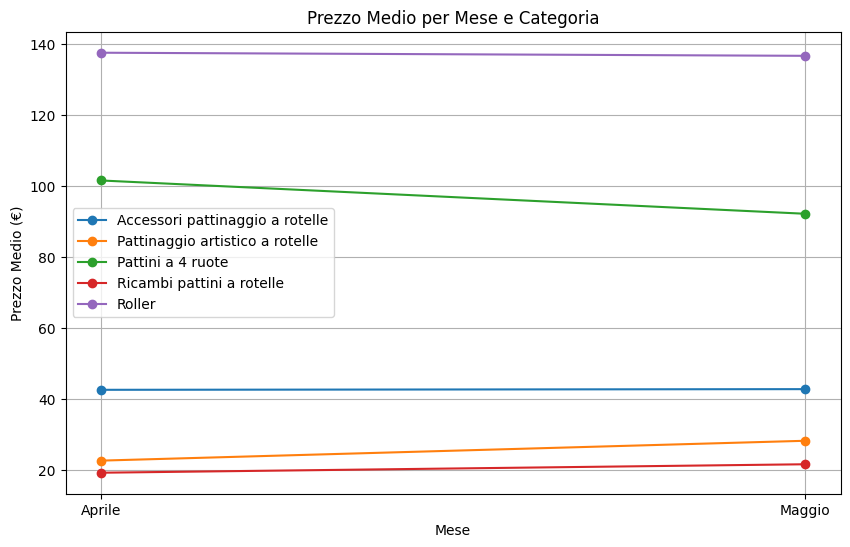

In [13]:
# Query
pipeline = [
    {
        "$group": {
            "_id": {
                "mese": {"$month": {"$toDate": "$scraped_at"}},
                "categoria": "$category"
            },
            "prezzo_medio": {"$avg": "$price(€)"}
        }
    },
    {"$sort": {"_id.mese": 1, "_id.categoria": 1}}
]
risultati = list(collection.aggregate(pipeline))

# Organizza dati
mesi = ['Aprile', 'Maggio']
categorie = sorted(set(r['_id']['categoria'] for r in risultati))
data = {cat: [0, 0] for cat in categorie}
for r in risultati:
    mese_idx = r['_id']['mese'] - 4
    data[r['_id']['categoria']][mese_idx] = r['prezzo_medio']

# Grafico
plt.figure(figsize=(10, 6))
for cat in categorie:
    plt.plot(mesi, data[cat], marker='o', label=cat)
plt.title('Prezzo Medio per Mese e Categoria')
plt.xlabel('Mese')
plt.ylabel('Prezzo Medio (€)')
plt.legend()
plt.grid(True)
plt.show()

### Grafico: Sconto medio settimanale

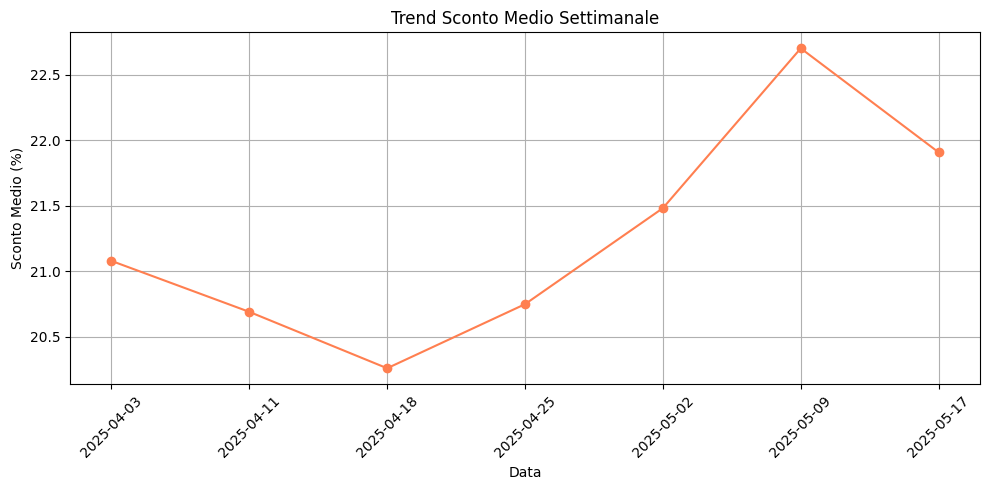

In [17]:
# Query
pipeline = [
    {
        "$group": {
            "_id": {
                "$dateToString": {
                    "format": "%Y-%m-%d",
                    "date": {"$toDate": "$scraped_at"}
                }
            },
            "sconto_medio": {"$avg": "$sale%"}
        }
    },
    {"$sort": {"_id": 1}}
]
risultati = list(collection.aggregate(pipeline))

# Dati per il grafico
date = [r['_id'] for r in risultati]
sconti = [r['sconto_medio'] for r in risultati]

# Grafico
plt.figure(figsize=(10, 5))
plt.plot(date, sconti, marker='o', color='coral')
plt.title('Trend Sconto Medio Settimanale')
plt.xlabel('Data')
plt.ylabel('Sconto Medio (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Trend dello sconto medio per categoria

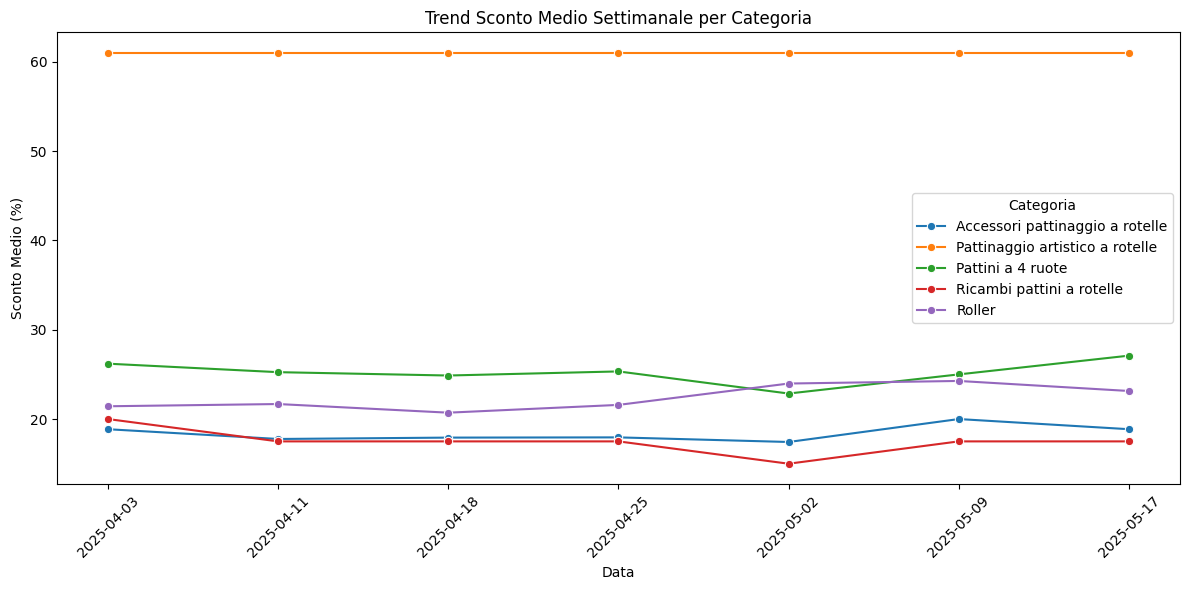

In [63]:
# Query con categoria
pipeline = [
    {
        "$group": {
            "_id": {
                "data": {
                    "$dateToString": {
                        "format": "%Y-%m-%d",
                        "date": {"$toDate": "$scraped_at"}
                    }
                },
                "categoria": "$category"
            },
            "sconto_medio": {"$avg": "$sale%"}
        }
    },
    {"$sort": {"_id.data": 1, "_id.categoria": 1}}
]
risultati = list(collection.aggregate(pipeline))

# Dati per il grafico
df = pd.DataFrame([
    {
        "Data": r['_id']['data'],
        "Categoria": r['_id']['categoria'],
        "Sconto medio (%)": r['sconto_medio']
    }
    for r in risultati
])

plt.figure(figsize=(12,6))
sns.lineplot(
    data=df,
    x="Data",
    y="Sconto medio (%)",
    hue="Categoria",
    marker="o"
)
plt.title("Trend Sconto Medio Settimanale per Categoria")
plt.xlabel("Data")
plt.ylabel("Sconto Medio (%)")
plt.xticks(rotation=45)
plt.legend(title="Categoria")
plt.tight_layout()
plt.show()

### Trend dello sconto medio per categoria (Aprile)

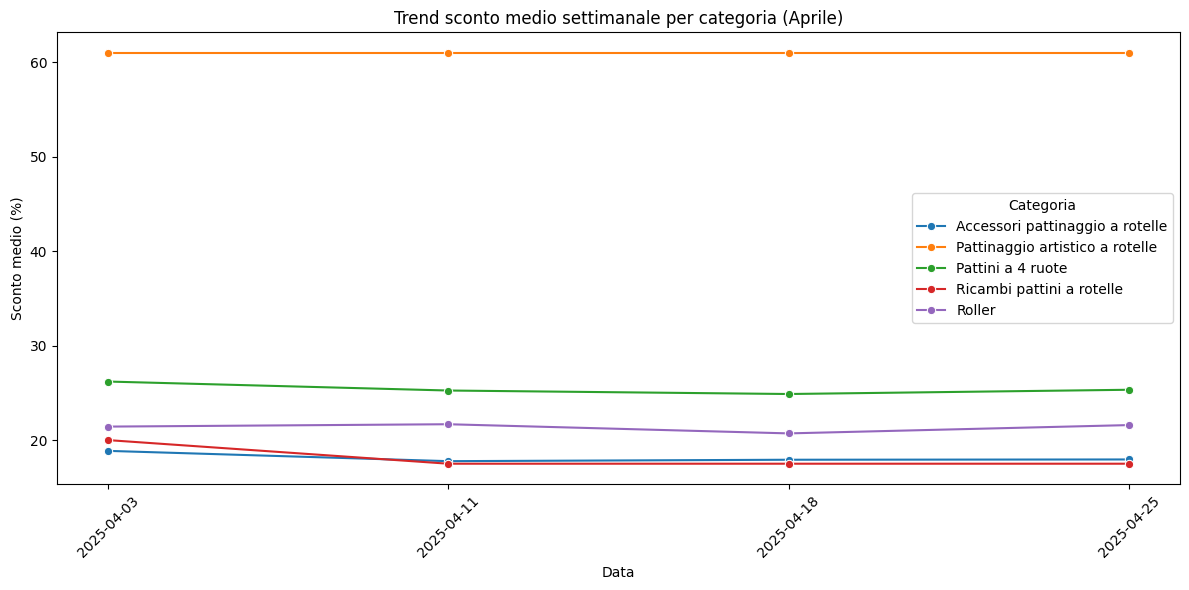

In [35]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=avg_week_cat_sale_df4,
    x="Data",
    y="Sconto medio (%)",
    hue="Categoria",
    marker="o"
)
plt.title("Trend sconto medio settimanale per categoria (Aprile)")
plt.xlabel("Data")
plt.ylabel("Sconto medio (%)")
plt.xticks(rotation=45)
plt.legend(title="Categoria")
plt.tight_layout()
plt.show()

### Trend dello sconto medio per categoria (Maggio)

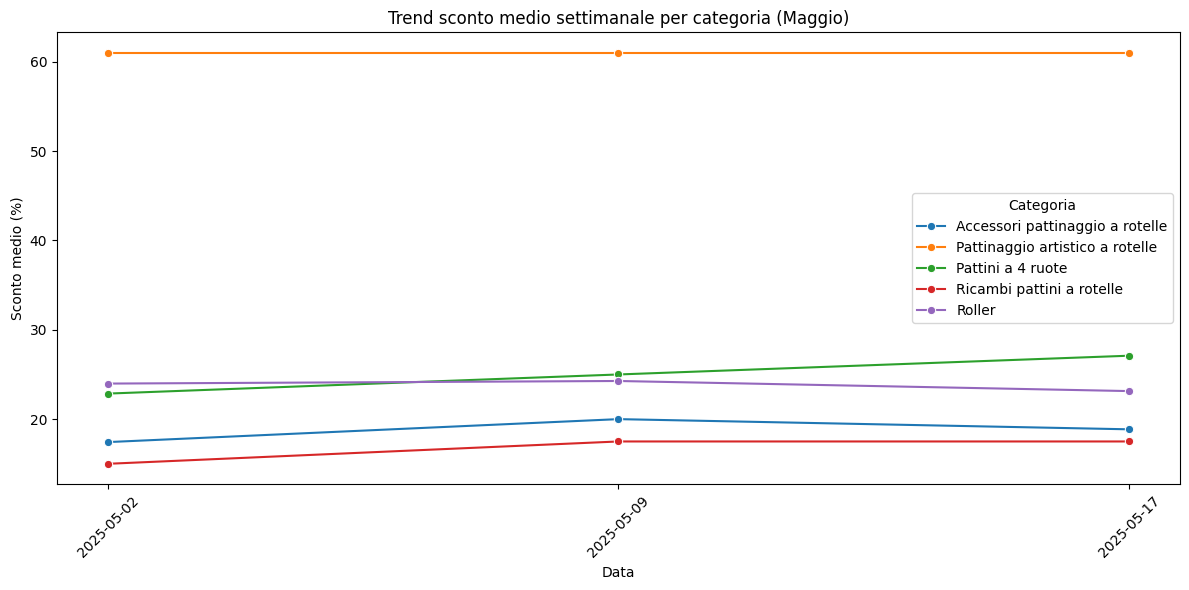

In [36]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=avg_week_cat_sale_df5,
    x="Data",
    y="Sconto medio (%)",
    hue="Categoria",
    marker="o"
)
plt.title("Trend sconto medio settimanale per categoria (Maggio)")
plt.xlabel("Data")
plt.ylabel("Sconto medio (%)")
plt.xticks(rotation=45)
plt.legend(title="Categoria")
plt.tight_layout()
plt.show()

###  Barplot dello sconto medio totale per categoria

/var/folders/9h/gj3b5f4143zflbdh9fh5lg4r0000gn/T/ipykernel_1496/55038760.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


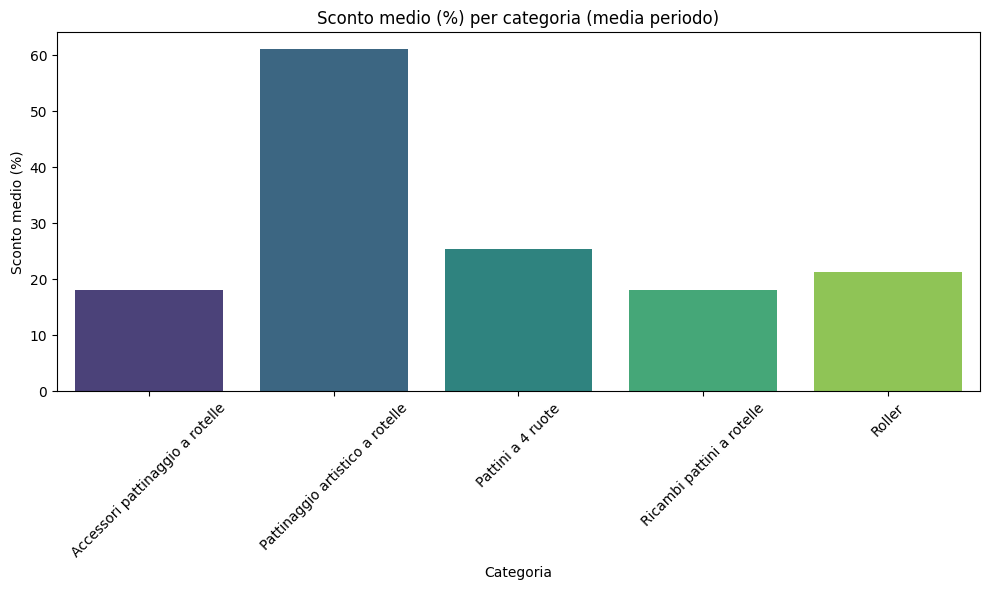

In [37]:
plt.figure(figsize=(10,6))
media_per_cat = avg_week_cat_sale_df4.groupby("Categoria")["Sconto medio (%)"].mean().reset_index()
sns.barplot(
    data=media_per_cat,
    x="Categoria",
    y="Sconto medio (%)",
    palette="viridis"
)
plt.title("Sconto medio (%) per categoria (media periodo)")
plt.xlabel("Categoria")
plt.ylabel("Sconto medio (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Grafico: Top 5 prodotti per recensioni

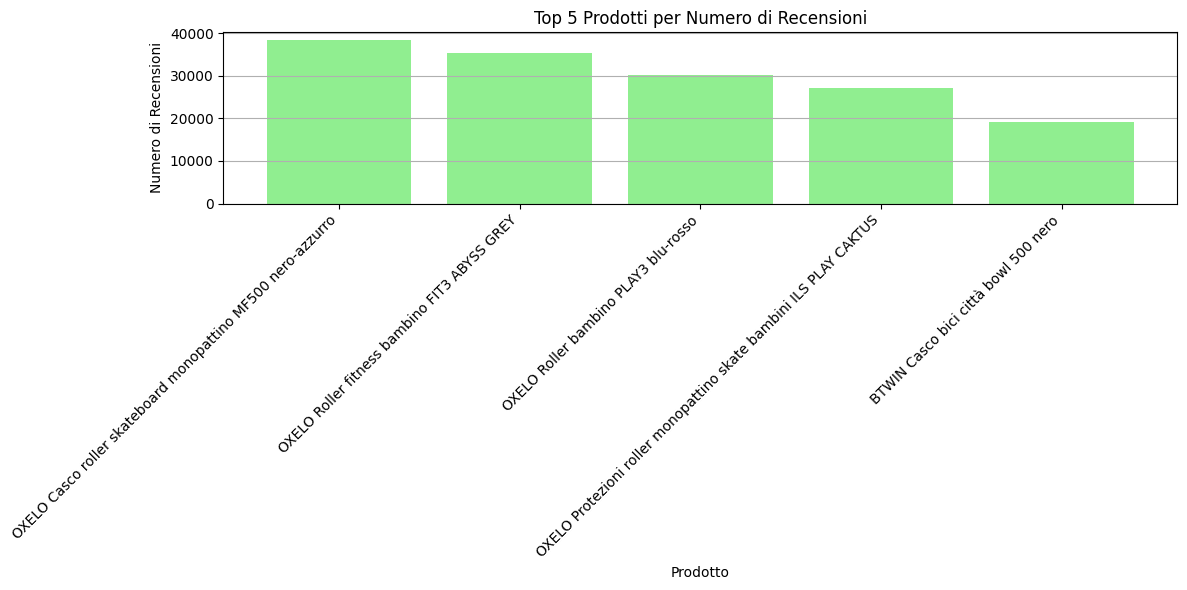

In [38]:
# Query
pipeline = [
    {"$group": {"_id": {"nome": "$name", "brand": "$brand"}, "recensioni_totali": {"$sum": "$num_reviews"}}},
    {"$sort": {"recensioni_totali": -1}},
    {"$limit": 5}
]
risultati = list(collection.aggregate(pipeline))

# Dati per il grafico
prodotti = [f"{r['_id']['brand']} {r['_id']['nome']}" for r in risultati]
recensioni = [r['recensioni_totali'] for r in risultati]

# Grafico
plt.figure(figsize=(12, 6))
plt.bar(prodotti, recensioni, color='lightgreen')
plt.title('Top 5 Prodotti per Numero di Recensioni')
plt.xlabel('Prodotto')
plt.ylabel('Numero di Recensioni')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

### Grafico: Recensioni medie per intervallo di sconto

/var/folders/9h/gj3b5f4143zflbdh9fh5lg4r0000gn/T/ipykernel_1055/2804534497.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


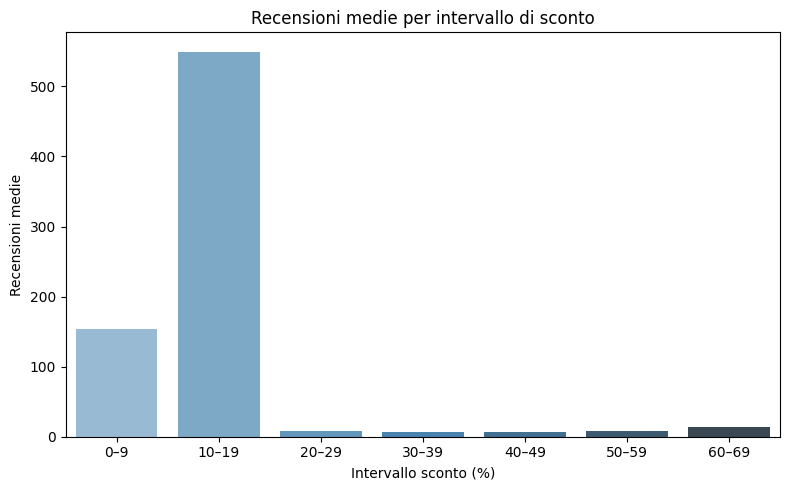

In [31]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=kpi12_df,
    x="Intervallo sconto (%)",
    y="Recensioni medie",
    palette="Blues_d"
)
plt.title("Recensioni medie per intervallo di sconto")
plt.xlabel("Intervallo sconto (%)")
plt.ylabel("Recensioni medie")
plt.tight_layout()
plt.show()